# <font color = '88C273'> Programming for Data Science Project

### 0- Imports


In [1]:
import pandas as pd
import numpy as np

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import bs4
import bs4
from bs4 import BeautifulSoup as BS

from tqdm import tqdm

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options

The libraries we used had the following versions:
- numpy version: 1.26.4
- pandas version: 2.2.3
- plotly version: 5.24.1
- matplotlib version: 3.8.0
- requests version: 2.31.0
- beautifulsoup4 version: 4.12.3
- tqdm version: 4.67.1
- selenium version: 4.27.0
- seaborn version: 0.13.2

In [2]:
# Display versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("plotly version:", plotly.__version__)
print("matplotlib version:", matplotlib.__version__)
print("requests version:", requests.__version__)
print("beautifulsoup4 version:", bs4.__version__)  # bs4 package
print("tqdm version: 4.67.1")
print("selenium version:", webdriver.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.1.1
pandas version: 2.2.3
plotly version: 5.24.1
matplotlib version: 3.9.2
requests version: 2.32.3
beautifulsoup4 version: 4.12.3
tqdm version: 4.67.1
selenium version: 4.26.1
seaborn version: 0.13.2


In [3]:
df = pd.read_csv("nova_ims_teaching_staff_2024-12-20.csv")

### 1- Web Scraping

**Phase 1.** First, we will obtain all links pointing to each teacher's page

In [4]:
link1 ='https://www.novaims.unl.pt/en/nova-ims/teaching-staff'

In [5]:
# Configure browser options
options = Options()

# Initialize the browser
browser_c = webdriver.Chrome(options=Options())
browser_c.get(link1)
browser_c.implicitly_wait(10)

In [6]:
# Handle privacy pop up
privacy_button = browser_c.find_element(By.XPATH, '/html/body/div[2]/div/div/div/div/div[3]/div[1]/button[3]')
privacy_button.click()

In [7]:
def find_links():
    """
    On the current web page of the web crawler, scrape each teachers' page link.
    """
    links = []

    # Extract the page source and parse it with BeautifulSoup
    page = browser_c.page_source
    soup = BS(page, 'html.parser')

    # Locate the section containing teacher links
    box = soup.find('div', {'class': 'content content--grid'})
    boxes = box.find_all('div', {'class': 'card-avatar__wrap'})

    # Extract and append links to the list
    for item in boxes:
        links.append(item.find('a').find_next('a')['href'])

    return links

In [8]:
# Defines the necessary objects to make the web crawler wait (10s) for pages to load and make buttons accessible
wait = WebDriverWait(browser_c, 10, poll_frequency=1)
actions = ActionChains(browser_c)

In [9]:
def next_page():
    """
    Makes the web crawler go to the next page
    """
    # Waits until the button (to go to the next page) becomes visible and can be interacted with
    button = wait.until(EC.visibility_of_element_located((By.XPATH,' /html/body/main/div[2]/div/div/nav/button[2]')))
    # Hover the pointer over the button
    actions.move_to_element(button).perform()

    # If this is the last page (button is disabled), then stop and signal it
    if button.get_attribute('disabled') == 'true':
        return -1  # This is a flag to signal that the crawler has ran out of pages

    # Navigate to the next page (if there is one)
    button.click()

In [10]:
ALL_LINKS = [] # Initialise a list that will contain every link to each teachers' individual pages

# Scrape links from the initial page and add then to the list
l = find_links()
ALL_LINKS.append(l)

browser_c.set_page_load_timeout(10) # set 10s as the maximum time to wait for page load
i = 0 # set up an iteration counter

# Iterate through all the pages to get all the links
while 1:
    browser_c.implicitly_wait(10)
    
    # Exit the loop if there are no more pages
    if next_page() == -1:
        break

    # Wait for the page's content to load
    wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="content"]/div[2]/div/div/div[2]/ul/li[1]/div/div/a[2]'))) 
    
    # Scrape links from the current page and add them to the list
    l = find_links()
    ALL_LINKS.append(l)

    # Debug print to track progress
    print(f"Iteration number {i}")
    i += 1

Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Iteration number 6
Iteration number 7
Iteration number 8
Iteration number 9
Iteration number 10
Iteration number 11


In [11]:
SINGULAR_LINKS = []

# Flatten the list of links from all pages
for page in ALL_LINKS:
    for link in page:
        SINGULAR_LINKS.append(link)

#len(SINGULAR_LINKS)

In [12]:
browser_c.quit()  # Quit the browser

**Phase 2.** Given the individual links, web scrape each of them to obtain the necessary information and transform them in a dataframe

In [13]:
# Initialise the dictionary that will store the scraped data
staff = {
    'Name': [],
    'Title': [],
    'Courses': [],
    'Publications': [],
    'Biography': []
}     

In [14]:
def scraping(link):
    """
    Parameters:
    link: the link to a teacher's page

    Action:
    Scrapes a teacher's page for their information
    """

    # Get the webpage's content and parse it with Beautiful Soup
    result = requests.get(link)
    soup = BS(result.text, 'html.parser')

    # Scrape the teachers's NAME
    name = soup.find(class_ = "card-avatar__heading gamma").text
    staff['Name'].append(name)

    # Scrape the teachers's TITLE
    title = soup.find(class_ = "card-avatar__posheading").text.split('\r')
    staff['Title'].append(title[0])

    # Scrape the teacher's COURSES
    all_courses = soup.find(class_ = "card-avatar__list").text.split('\n')
    courses = ''
    for name in all_courses:
        if name != '':
            if courses == '':
                courses = courses + name
            else:
                courses = courses + ', ' + name
    staff['Courses'].append(courses)

    # Scrape the teacher's number of PUBLICATIONS
    is_publi = soup.find(class_="content__heading has-border beta")
    if is_publi.next_sibling:
        publications = soup.find_all(class_="search-results__article")
        count = 0
        for publi in publications:
            pos_heading = publi.find(class_='search-results__heading gamma')
            if pos_heading.text != '':
                count +=1
        staff['Publications'].append(count)
    else:
        staff['Publications'].append(0)

    # Scrape the teacher's BIOGRAPHY
    biography = soup.find(class_='content__copy').text
    if biography != '':
        staff['Biography'].append(biography)
    else:
        staff['Biography'].append(np.nan)


In [15]:
# Iterate through all the links, and scrape the teachers' info
for link in tqdm(SINGULAR_LINKS):  # see the scraping progress through a progress bar with tqdm library
    scraping(link)

  0%|          | 0/231 [00:00<?, ?it/s]

100%|██████████| 231/231 [01:52<00:00,  2.05it/s]


In [16]:
#len(staff['Name'])

In [17]:
# Convert the dictionary into a DataFrame
staff_df1 = pd.DataFrame(staff)

In [18]:
staff_df1

,Name,Title,Courses,Publications,Biography
0,Afonso Malheiro,Adjunct Lecturer,Web Analytics,0,Bachelor's degree in Management (Catholic Univ...
1,Afshin Ashofteh,Invited Assistant Professor,"Banking and Insurance Economics, Credit Risk S...",21,Afshin Ashofteh is a full-time University Prof...
2,Alexandra Variz,Adjunct Lecturer,Digital Marketing & E-Commerce,0,"Currently, I am working as a Digital Marketing..."
3,Alexandre Guilherme Marques,Adjunct Lecturer,Deep Learning,0,Alexandre Marques is an assistant professor at...
4,Alexandre Neto,Adjunct Lecturer,Group Project Seminar on Programming and Analysis,0,Bachelor's degree in Geographical Engineering ...
...,...,...,...,...,...
226,Vítor Santos,Assistant Professor,"Architectures for Information Systems, Artific...",111,"Vitor Santos, is an Assistant Professor at NOV..."
227,Yasser Al Helaly,Invited Teaching Assistant,"Applied Cybersecurity, Cybersecurity, Research...",4,PhD researcher at NOVA IMS MagIC and a compute...
228,Yuri Binev,Professor of the Practice,"Data Management and Storage, Storing and Retri...",0,Information available soon.
229,Yuriy Perezhohin,Research Assistant,"Deep Learning, Deep Learning",4,Yuriy Perezhohin is a PhD student in Informati...


**Phase 3.** Compare with the given dataframe to check for correctness

In [19]:
# Merge our dataset and the professor's dataset with an outer join to identify differences
comparison = pd.merge(staff_df1, df, indicator=True, how='outer')
# Filter the rows where there are differences (rows that are not in both dataframes)
differences = comparison[comparison['_merge'] != 'both']
differences

,Name,Title,Courses,Publications,Biography,_merge


In [20]:
# Compare the two dataframes and show the differences in values
comparison = staff_df1.compare(df)
comparison

Empty DataFrame
Columns: []
Index: []

In [21]:
if comparison.empty:
    print("The DataFrames are equal!")
else:
    print("The DataFrames have differences!")

The DataFrames are equal!


### 2- Data Wrangling and Analysis

In [22]:
del df
df = staff_df1.copy() # Use dataframe extracted from web scraping

#### Q1. Detect and treat duplicated/missing values

Before answering the first question we decided to check some information about the dataset at hand by head() method

In [23]:
df.head()

,Name,Title,Courses,Publications,Biography
0,Afonso Malheiro,Adjunct Lecturer,Web Analytics,0,Bachelor's degree in Management (Catholic Univ...
1,Afshin Ashofteh,Invited Assistant Professor,"Banking and Insurance Economics, Credit Risk S...",21,Afshin Ashofteh is a full-time University Prof...
2,Alexandra Variz,Adjunct Lecturer,Digital Marketing & E-Commerce,0,"Currently, I am working as a Digital Marketing..."
3,Alexandre Guilherme Marques,Adjunct Lecturer,Deep Learning,0,Alexandre Marques is an assistant professor at...
4,Alexandre Neto,Adjunct Lecturer,Group Project Seminar on Programming and Analysis,0,Bachelor's degree in Geographical Engineering ...


To determine if there were missing values in the dataset, the info()  method was used, which would tell us how many Non-Null entries were. Therefore, we could see if there were any missing values.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          231 non-null    object
 1   Title         231 non-null    object
 2   Courses       231 non-null    object
 3   Publications  231 non-null    int64 
 4   Biography     226 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.2+ KB


It was concluded that there are missing values in Biography. We then proceeded to check if there were any duplicates.

In [25]:
# check for duplicates
dups = df[df['Name'].duplicated() == True]
dups

,Name,Title,Courses,Publications,Biography


We do not have any duplicates in the dataset. Therefore, no action is needed.

In [26]:
# Find the missing values
missings = df[df.isna().any(axis=1)]
missings

,Name,Title,Courses,Publications,Biography
10,Ana Pena,Adjunct Lecturer,"Marketing Strategy and Innovation, Startup Ven...",0,NaN
50,Fátima Neves,Invited Assistant Professor,"Research Methodologies, Research Methods, Rese...",9,NaN
56,Filipe Nunes,Professor of the Practice,Intelligence Services and Political Regimes,0,NaN
76,Isabel Dias,Adjunct Lecturer,"Sampling and Estimation, Sampling Theory and M...",0,NaN
101,José Carlos Costa da Silva Teixeira,Adjunct Lecturer,Big Data Analytics for Business,0,NaN


Our approach to treat the missing biographies is by creating generic ones. This decision was taken because, as it would be needed to deal with the professors biographies afterwards, filling those missing entries with generic texts would ensure the data integrity.

In [27]:
def create_generic_bio(name, title, courses):
    """
    Creates a generic biography for a teacher, given its Name, Title and Courses taught.
    """
    return f"{name} is a{"n"*(title[0] in ["a", "e", "i", "o"])} {title} at NOVA IMS. Currently teaches the following courses: {courses}"

for index, row in missings.iterrows():
    df.loc[index, "Biography"] = (create_generic_bio(row['Name'], row['Title'].lower(), row['Courses']))

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          231 non-null    object
 1   Title         231 non-null    object
 2   Courses       231 non-null    object
 3   Publications  231 non-null    int64 
 4   Biography     231 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.2+ KB


After using the info() method it was concluded that missing values have been filled.

#### Q2. Which teachers have...

In [29]:
df_ = df.copy() # Make a copy of the dataset to not affect the original one as we will be adding new columns to it

##### a. the highest wordcount (top 1, name only)?

To answer to this question, firstly we needed to preprocess the biographies. For that, a functio was created.

In [30]:
def preprocess(text):
    """
    Parameters:
    text: a strung to be preprocessed

    Action:
    Preprocesses a given text by lowercasing it, removing punctuation and removing extra spaces

    Returns:
    text: the preprocessed text
    """
    text = text.lower()
    
    punct = [',','.',':', ';','!','?', '(', ')', '[', ']', '{', '}', '"', "'"]
    for p in punct:
        text = text.replace(p, ' ')
        
    while '  ' in text:
        text = text.replace('  ', ' ')
        
    return text

Afterwards, a function was created in order to check the length of the biographies.

In [31]:
def wordcount(bio):
    """
    Parameters:
    bio: a string containing the biography of a teacher

    Action:
    Counts the number of words of the Biography

    Returns:
    len(bio): number of words in the biography
    """
    bio = preprocess(bio).split(' ')
    return len(bio)

And, finally, the professor with the biggest wordcount was calculated.

In [32]:
bio_count = [] # Initialise a list to contain the wordcounts of all the professors

# Iterate through the biographies of the teachers and wordcount
for idx in df_.index:
    bio = df_['Biography'][idx] # Get the bio through the index
    bio_count.append(wordcount(bio))

# Add wordcount as a column in the DataFrame as it will be useful for later too
df_['wordcount'] = bio_count

# Get the name of the teacher with the highest wordcount
df_.sort_values('wordcount', ascending=False).reset_index().loc[0,'Name']

'Miguel de Castro Neto'

We may conclude that, Professor Miguel de Castro Neto has the biggest wordcount.

##### b. the highest coursecount (top 5)

To answer this question a funtion was created in order to get the coursecount of every teacher.

In [33]:
def coursecount(text):
    """
    Parameters:
    text: a string containing only the courses

    Action:
    Counts the number of courses taught

    Returns:
    len(text): number of courses taught by a teacher
    """
    text = text.split(', ')
    return len(text)

In [34]:
course_count = [] # Initialise a list to contain the coursecounts of all the professors

# Iterate through the courses of the teachers and coursecount
for idx in df_.index:
    courses = df_['Courses'][idx] # Get the courses through the index
    course_count.append(coursecount(courses))

# Add coursecount as a column in the DataFrame as it will be useful for later
df_['coursecount'] = course_count

# Get the names of the 5 teachers that teach most courses
df_.sort_values('coursecount', ascending=False).reset_index().loc[:4,'Name']

0            Joana Neves
1    Guilherme Victorino
2      Roberto Henriques
3      Diego Costa Pinto
4           Bruno Jardim
Name: Name, dtype: object

As we can see the top 5 teacher with the most courses, are listed above.

##### c. most publications (top 10)

To answer this question, only the sort_values was used with ascending defined as False, so that we got the descending order of professors with most publications.

In [35]:
df_.sort_values('Publications', ascending=False).reset_index().loc[:9,'Name']

0           Tiago Oliveira
1           Mauro Castelli
2       Leonardo Vanneschi
3             Marco Painho
4    Miguel de Castro Neto
5             Vítor Santos
6           Fernando Bação
7              Jorge Bravo
8        Diego Costa Pinto
9        Roberto Henriques
Name: Name, dtype: object

As we can see the top 10 teachers with the most publications, are listed above.

#### Q3. Variables' Distribution

##### a. How are the wordcount, coursecount and publications distributed and related?

To see how the 3 variables are distributed, we will plot their histograms and boxplots.

In [36]:
# Define the columns we want to study
cols = ['Publications', 'wordcount', 'coursecount']
color = ['#72BF78', '#A0D683', '#D3EE98'] # Define 3 different colors for the 3 different columns

fig = make_subplots(
    rows=2, cols=3, shared_xaxes=False, subplot_titles=cols   # Initialise 6 subplots
    )

In [37]:
# Plot the distribution of each variable in the 1st row
for i, col in enumerate(cols):
    fig.add_trace(
        go.Histogram(x=df_[col], name = col, marker_color= color[i]),
        row=1, col=i+1)

# Plot boxplots for each variable in the 2nd row
for i, col in enumerate(cols):
    fig.add_trace(
        go.Box(y=df_[col], name = col, marker_color = color[i]),
        row=2, col=i+1)

# Add a title
fig.update_layout(title='Distribution of the variables', legend_title_text='Variable', legend_title_font_size=15, height = 800)
fig.show()

- **Publications**: The majority of professors have 0 to 9 publications but there are teachers with up to 229 publications.
- **wordcount**: The most common is for a biography to have between 60 and 79 words, however, unlike in the publications number, the difference from that interval to the others is not drastic.
- **coursecount**: Most professors teach 1 course, but there are professors with up to 16 courses.

To see how the 3 variables are related, we will plot their correlation heatmap.

In [38]:
# Calculate their correlation
cr = df_.corr(numeric_only=True)

# Plot the heatmap
fig = go.Figure(go.Heatmap(
    x = cr.columns,
    y = cr.columns,
    z = cr.values.tolist(),
    colorscale = 'emrld',
    zmin = -1,
    zmax = 1))

# Add title
fig.update_layout(title='Correlation of variables', height = 500)
fig.show()

- **Publications and coursecount**: This value indicates a moderate positive correlation between the 2 variables: professors with a higher number of publications may be the ones with a higher number of courses, although it is not a super strong correlation
- **Publications and wordcount**: These variables have a weak positive correlation between them, which means that there exists a small positive correlation between the number of publications and the number of words in a Biography of a professor
- **coursecount and wordcount**: These variables have the weakest positive correlation, which means that there is a small positive relation between the number of courses taught by a professor and the number of words in that professor Biography

##### b. Are there differences in those variables for different types of teachers

To analyse the the number of Publications, courses and words for the different types of teachers, we will plot Bar Charts for each variable.

In [39]:
fig = make_subplots(
    rows=1, cols=3, shared_xaxes=False, subplot_titles=cols  # Initialise 3 subplots
    )

In [40]:
# Plot the mean value of each variable per professional Title
for i, col in enumerate(cols):
    df1 = df_.groupby(['Title'])[col].mean().reset_index() # Group the DataFrame by Title, with the aggregation function Mean
    fig.add_trace(
        go.Bar(x=df1['Title'], y=df1[col], name = col, marker_color= color[i]),
        row=1, col=i+1)

# Add a title
fig.update_layout(title='Distribution of variables per Professor Title', legend_title_text='Variable', 
                  legend_title_font_size=15, height = 400)
fig.show()

In all the variables, there are differences for different types of professor.
- **Publications**: Full Professors have a higher number of publications, maybe reflecting their bigger experience;
- **wordcount**: Full Professors, Associate Professors and Invited Full Professors are the ones with a higher biography wordcount, which might mean they are the ones with more work experience;
- **coursecount**: Assistant Professors are the ones with a higher course count, followed by Full Professors and Associate Professors, while Invited Profesors are the ones with a lower course count, which may reflect their temporary roles.

#### Q4. Insights about Courses

##### a) How many different courses (unique course names) are taught at NOVA IMS?

This question was answered by creating a list with all with all courses thaught and then applying the nunique() method to get the number of different courses.

In [41]:
# Get a list of all the course names in the DataFrame
all_courses = df_['Courses'].str.split(',').explode().str.strip()

# Count the number of unique courses
unique_courses_count = all_courses.nunique()

print(f"There are {unique_courses_count} courses taught at NOVA IMS.")

There are 278 courses taught at NOVA IMS.


As seen, there are 278 courses at NOVA IMS.

##### b) How many courses (unique course names) are taught by only one teacher?

Note: The courses taught by only 1 teacher are the ones that appear in the list of all courses only 1 time!

In [42]:
# Count the number of times each course appears in the list
course_teacher_counts = all_courses.value_counts()
# Get the courses that appear only once
courses_taught_by_one_teacher = course_teacher_counts[course_teacher_counts == 1]

print(f"There are {len(courses_taught_by_one_teacher)} courses taught by only 1 teacher.")

There are 138 courses taught by only 1 teacher.


##### c) What's the probability of someone teaching 'Data Mining I' also teaching ‘Data Mining II'?

In [43]:
# Step 1: Check which teachers teach exactly "Data Mining I"
teaches_data_mining_i = all_courses[all_courses == 'Data Mining I']

# Step 2: Check which of those teachers also teach "Data Mining II"
 # Step 2.1: Find the original teacher index for those who teach "Data Mining I"
data_mining_i_indices = teaches_data_mining_i.index.unique()

 # Step 2.2: Create a mask for teachers who teach both "Data Mining I" and "Data Mining II"
teaches_data_mining_ii_and_i = []
for idx in data_mining_i_indices:
    courses_by_teacher = all_courses.loc[idx]
    if 'Data Mining II' in courses_by_teacher.values:
        teaches_data_mining_ii_and_i.append(idx)

# Step 3: Calculate the probability
probability = len(teaches_data_mining_ii_and_i) / len(data_mining_i_indices) if len(data_mining_i_indices) > 0 else 0

print(f"The probability of a teacher teaching Data Mining I also teaching Data Mining II is {round(probability, 4)}.")

The probability of a teacher teaching Data Mining I also teaching Data Mining II is 0.4286.


#### Q5 - Aditional insights

##### 1) Calculate courses proportion by teacher (e.g. teacher X teaches n% of the courses of NOVA IMS)
**Motivation**: Quantify the *"amount of teaching workload participation"* into a numerical value, in the form of a proportion. With this derived variable, we glean insights on the teachers' participation in teaching.

Note: The course Proportion of a teacher is the number of courses they teach, divided by the number of courses in NOVA IMS.

In [44]:
# Create a new row on the DataFrame of the Proportion
df_['Course Participation'] = df_['coursecount'] / unique_courses_count 
                                            # unique_courses_count is the number of courses taught at NOVA IMS

df_.sort_values('Course Participation', ascending=False).reset_index().loc[:10,['Name', 'Course Participation']]

,Name,Course Participation
0,Joana Neves,0.057554
1,Guilherme Victorino,0.053957
2,Roberto Henriques,0.050360
3,Diego Costa Pinto,0.043165
4,Bruno Jardim,0.043165
5,Pedro Simões Coelho,0.043165
6,Frederico Cruz Jesus,0.039568
7,Fernando Bação,0.039568
8,Mauro Castelli,0.039568
9,Bruno Damásio,0.039568


##### 2) Find the top 10 courses with most teachers
**Motivation**: Make an interesting observation on *question 4b)*, by looking at the courses with the *most* teachers, instead of the contrary (i.e. courses with only one teacher). In this way we can understand what is the highest number of the teachers for a course, or look for potential "outliers".

In [45]:
# Split the courses into a list (instead of a string)
df_['Courses_lt'] = df_['Courses'].apply(lambda x: x.split(', '))
# Get rid of duplicated courses (inside the same teacher)
df_['Courses_lt'] = df_['Courses_lt'].apply(lambda x: list(set(x)))

# Explode Courses_lt into separate rows
exploded_df = df_.explode('Courses_lt')
# Count the number of times each course appears
course_count = exploded_df['Courses_lt'].value_counts().reset_index()

# Rename the columns for better interpretability
course_count.columns = ['Course Name', 'Teacher Count']

In [46]:
course_count.head(10)

,Course Name,Teacher Count
0,Research Methods,45
1,Research Methodologies,45
2,Programming for Data Science,8
3,Business Process Management,8
4,Machine Learning,7
5,Data Mining I,7
6,Business Intelligence,6
7,Geospatial Data Mining,6
8,Digital Marketing & E-Commerce,6
9,Data Mining II,5


##### 3) How many courses are structured in different parts? (E.g. Math I and Math II, or Databases 1 and Databases 2)
**Motivation**: Question 4c) asked us to calculate the probability of a someone teaching Data Mining I and II at the same time. We thought that it would have been interesting to generalize this question further, by asking ourselves which courses follow a similar structure (i.e. being split into multiple parts).

To find out how many courses were structured with different parts we decided to look for every course that has at least 2 parts. This was done because, every course that has 2 parts has at least one part.

In [47]:
parts = []  # Initialise a list to keep all courses which are a part II

# Iterate through the courses and see which ones have are a part II
for course in list(course_count['Course Name']):
    if ' II' in course and ' III' not in course:
        parts.append(course)

#print(parts)
print(f'There are {len(parts)} courses with at least 2 parts.')

There are 12 courses with at least 2 parts.


The next step was to create a list of lists. Each list inside the main list would have the names from all the courses with different parts. For example, Data Mining I and Data Mining II would be in a list. In order to do this, we would iterate through the previous list created and then through all the names in the Course Name column of the Data Frame created previously. We would then have an if. The first confiton checks if the substring `parts[i][:-1]` exists in the course name. The second condition ensures that when `parts[i][:-1]` doesn't match any course name a shorter substring `parts[i][:-3]` might still match.

In [48]:
# Initialize an empty list to score the lists with the courses
courses_parts = []

# Iterate throught the parts list
for i in range(len(parts)):
    # Create a sublist for every part
    part = []
    # Iterate throught the courses names
    for course in list(course_count['Course Name']):
        # Check for matching course names
        if parts[i][:-1] in course or (parts[i][:-1] not in list(course_count['Course Name']) and parts[i][:-3] in course):
            # append the matching course names to the sublist
            part.append(course)
    # add the sublist to the main list
    courses_parts.append(part)

courses_parts

[['Data Mining I', 'Data Mining II'],
 ['Business Intelligence I', 'Business Intelligence II'],
 ['Econometrics I', 'Econometrics II'],
 ['Research Seminar I', 'Research Seminar II', 'Research Seminar III'],
 ['Statistical Methods II', 'Statistical Methods I'],
 ['Machine Learning I', 'Machine Learning II'],
 ['Mathematical Analysis I', 'Mathematical Analysis II'],
 ['Databases I', 'Databases II'],
 ['Personal Development II', 'Personal Development I '],
 ['Information Project Management', 'Information Project Management II'],
 ['Computation  I', 'Computation  III', 'Computation  II'],
 ['Computational Statistics I', 'Computational Statistics II']]

In [49]:
# Create a DataFrame with the information of the 2 and 3 part courses
course_parts = pd.DataFrame({'Course':[parts[i][:-2] for i in range(len(parts))],
                             'Number of parts':[len(part) for part in courses_parts],
                             'Parts': courses_parts}, columns = ['Course', 'Number of parts', 'Parts'])

print(f"{len(course_parts)} courses are structured in different parts at NOVA IMS.")

12 courses are structured in different parts at NOVA IMS.


In [50]:
course_parts

,Course,Number of parts,Parts
0,Data Mining,2,"[Data Mining I, Data Mining II]"
1,Business Intelligence,2,"[Business Intelligence I, Business Intelligenc..."
2,Econometrics,2,"[Econometrics I, Econometrics II]"
3,Research Seminar,3,"[Research Seminar I, Research Seminar II, Rese..."
4,Statistical Methods,2,"[Statistical Methods II, Statistical Methods I]"
5,Machine Learning,2,"[Machine Learning I, Machine Learning II]"
6,Mathematical Analysis,2,"[Mathematical Analysis I, Mathematical Analysi..."
7,Databases,2,"[Databases I, Databases II]"
8,Personal Development,2,"[Personal Development II, Personal Development..."
9,Information Project Management,2,"[Information Project Management, Information P..."


### 3- Data Science in Action

#### Teachers Clustering
In the *"Data Science in Action"* part we decided to experiment with unsupervised learning techniques to perform clustering on the teachers dataset with the available numerical variables (namely wordcount, publications and courses count) and obtain meaningful insights - for example, we can try to understand if there are any patterns in the teacher's groups.

**Disclaimer**: The cluster analysis will be based on teachers dataset for the *18th December of 2024*; variations to the dataset, such as teachers adding one more publication or changing courses, could significantly affect the clustering process, thus the cluster analysis. If the clusters' labels and their descriptions do not match, this could be one of the reasons.

##### 3.0. - Imports for Data Science in Action

In [51]:
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
import scipy
from scipy.cluster.hierarchy import dendrogram

import collections
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

The libraries we used had the following versions:
- scikit-learn version: 1.5.2
- scipy version: 1.13.1
- nltk version: 3.9.1
- wordcloud version: 1.9.4


In [52]:
# Display versions
print("scikit-learn version:", sklearn.__version__)
print("scipy version:", scipy.__version__)
print("nltk version:", nltk.__version__)
print("wordcloud version: 1.9.4")

scikit-learn version: 1.5.2
scipy version: 1.14.1
nltk version: 3.9.1
wordcloud version: 1.9.4


##### 3.1. - Preliminary Inspection for Clustering
Before performing clustering we have to take a look at the dataset, by plotting a 3D scatterplot of the numerical variables.

**Note:** We did not use the variable "Course Participation" (see question *5a)* ), as it is strongly correlated with the "Coursecount" variable.

In [53]:
px.scatter_3d(df_, x='Publications', y='wordcount', z='coursecount') 

From the above plot, we can deduce the following (potential) issues:
- **Variable distribution and scaling**
    - Variables are not normally distributed and are not scaled, which could cause issues in metric-based clustering algorithms, such as KMeans.
- **Multi-and-singular-dimensional outliers**
    - We will consider using an algorithm that is able to detect multidimensional outliers, such as hierarchical clustering (implemented in Sklearn as `AgglomerativeClustering`)
- **Unevenly sized blobs**
    - We will address this problem by initializing KMeans (or any other clustering algorithms) more times with the hyperparameter `n_init`

##### 3.2. - Variables Transformation
We will deal with the first issue, by doing variable transformation.

As we inspected the variables' distribution previously, we have decided to do the following transformations:
- Use $\sqrt{\cdot}$ transformation on publications and wordcount, as they have a right-skew
- Perform robust scaling on every variable; we used it as all of the variables contain extreme values (outliers)

In [54]:
df_clustering = df_.copy()

# Transform
df_clustering['newP'] = (df_clustering.Publications**(1/2))
df_clustering['newW'] = (df_clustering['wordcount']**(1/2))
df_clustering['newC'] = df_clustering['coursecount']

# Scale
st = RobustScaler()
df_clustering['newP'] = st.fit_transform(df_clustering[['newP']])

st = RobustScaler()
df_clustering['newW'] = st.fit_transform(df_clustering[['newW']])

st = RobustScaler()
df_clustering['newC'] = st.fit_transform(df_clustering[['newC']])

# Define train subset
train = df_clustering[['newP', 'newW', 'newC']]

train.head(1)

,newP,newW,newC
0,0.0,-0.365005,-0.5


##### 3.3. - Clustering
Now we are finally ready to perform actual clustering

**Method Determination**

We will use *hierarchical clustering* for this task.

**Motivation**: Sparse entries and multidimensional outlier might make the KMeans clustering process less clear since it is sensitive to them. In fact, we can see that it worsens the silhoulette score (as seen on the graph below)

**Method:** Use hierarchical clustering, with average linkage distance. 

As the hyperparameter, we chose linkage distance as it seems to get the best silhoulette score (with k=4). On the graph, we can see this method outperforms the others, being able to cluster sparse entries and outliers quite effectively.

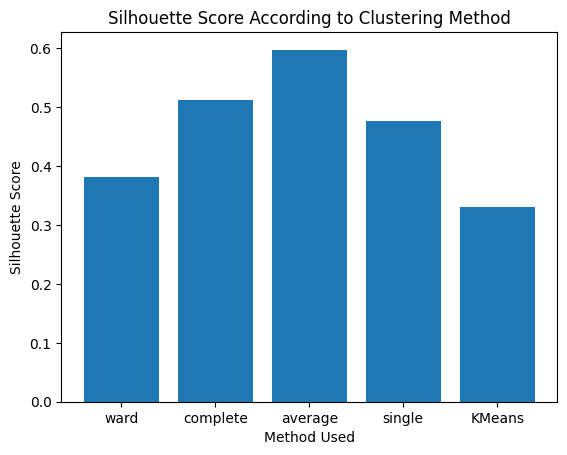

In [55]:
# Plot Silhoulette Score by Method Used
space = { 'linkage' : ['ward', 'complete', 'average', 'single']}
silhoulettes_c = {}

# Iterate through each linkage method
for hyper in space['linkage']:
    # Perform Agglomerative Clustering with 4 clusters and the current linkage method
    clusterer_s = AgglomerativeClustering(4, linkage=hyper)
    # Fit the model and predict the cluster labels
    labels = clusterer_s.fit_predict(train)
    # Score the clustering method (silhoulettes score)
    silhoulettes_c[hyper] = silhouette_score(train, labels)

# Perform KMeans clustering and get its silhoulettes score
clusterer_kmeans = KMeans(4, n_init=100)
labels_2 = clusterer_kmeans.fit_predict(train)
silhoulettes_c['KMeans'] = silhouette_score(train, labels_2)

# Create a bar plot to visualise the scores for each clustering method
plt.bar(silhoulettes_c.keys(), silhoulettes_c.values())
plt.title('Silhouette Score According to Clustering Method')
plt.xlabel('Method Used')
plt.ylabel('Silhouette Score')
plt.show()


**Clusters Number Determination**

To choose $n$, i.e. the number of clusters, we will use mainly two methods:
- We will analyze the dendogram produced by our hierarchical clusterer, and set a range of cut-off lines by the entry with the highest height (variance)
- We will also analyze the silhouette scores by each $n$ used

**Outputs**:
- According to the dendogram method, the ideal cut-off value is in the range $[4, 8]$
- According to the silhouette scores, the ideal cut-off value is in the range $[5,6]$<br>

Therefore, we will pick $n=5$.

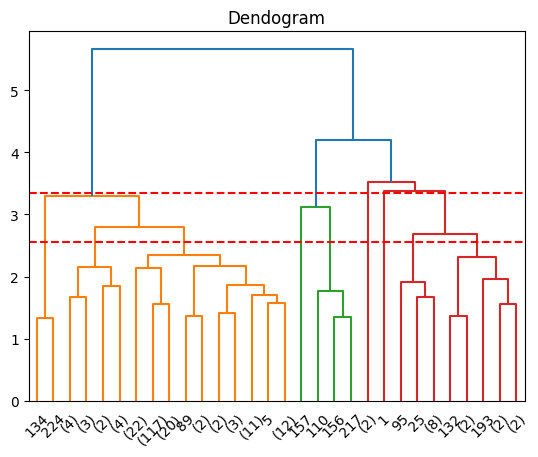

In [56]:
# Dendogram Method

def plot_dendrogram(model, **kwargs):
    """
    Plot a dendogram from a hierarchical clustering model
    
    Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    """
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create linkage matrix (required format for the dendogram)
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the dendrogram using the linkage_matrix
    dendrogram(linkage_matrix, **kwargs)

# Create an Agglomerative Clustering model with no specific number of clusters and fit it
clusterer_baseline = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
clusterer_baseline.fit(train)

# Plot its dendogram
plot_dendrogram(clusterer_baseline, truncate_mode='lastp', p=30)
# Add lines for visual reference
plt.axhline(3.35, color='r', linestyle='--')
plt.axhline(2.55, color='r', linestyle='--')
# Add title
plt.title('Dendogram')
plt.show()


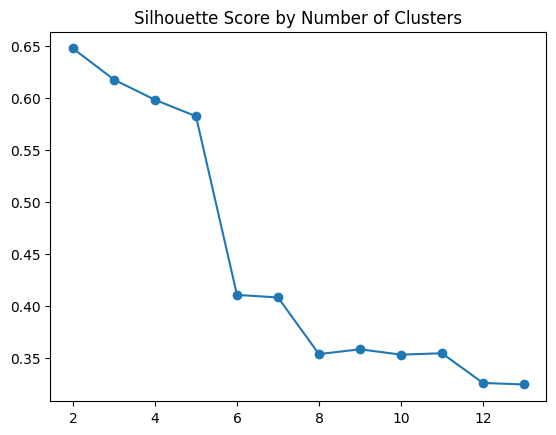

In [57]:
# Silhouette Scores Method

params = {'linkage': 'average'} 
silhoulettes_2 = {}

# Iterate through the possible numbers of clusters (2 to 13)
for i in range(2, 14):
    # Perform Agglomerative Clustering with the current number of clusters and average linkage
    clusterer_i = AgglomerativeClustering(i, **params)
    # Fit the model and predict the cluster labels
    labels = clusterer_i.fit_predict(train)
    # Score the clustering (silhoulettes score)
    silhoulettes_2[i] = silhouette_score(train, labels)

# Make a Line Plot of the Silhoelettes Scores by Number of Clusters
plt.plot(silhoulettes_2.keys(), silhoulettes_2.values(), marker='o')
# Add title
plt.title('Silhouette Score by Number of Clusters')
plt.show()

In [58]:
k = 5
# Perform Agglomerative Clustering with 5 clusters and average linkage
HierchicalClusterer = AgglomerativeClustering(k, **params)
labels = HierchicalClusterer.fit_predict(train)

# Add the predicted cluster labels to the DataFrame for visualisation
df_clustering['HCLabels'] = labels

# Create a 3D Scatter Plot to visualise the clusters!
px.scatter_3d(df_clustering, x='Publications', y='wordcount', z='coursecount', color='HCLabels') 

##### 3.4. - Cluster Analysis
As we have clustered the teachers in five different groups, it is time to do *cluster analysis*


---

**General Overview**

---

Generally, we can see that our clusterer was able to successfully find the multidimensional outliers, as seen in the 3D-scatterplot. 

In fact, we can see that *Group 0* contains the most teachers in the dataset, representing $89.18\%$ of it.

In [59]:
display(df_clustering[['Name', 'HCLabels']].groupby('HCLabels').count().style.bar())

,Name
HCLabels,
0,206
1,18
2,4
3,2
4,1


---

**Clusters 2, 3, 4**: Multidimensional Outliers (Full-Time Researchers, Assistant Professors and Professional-to-Academic Transitions)

---

Clusters 2, 3, 4 have the lowest count of teachers, meaning that they most likely represent multidimensional outliers. In particular, we have that:
- **Cluster 2** contains the teachers with a high amount of publications (averaging 187.25 publications) and a moderate amount of courses (from 6 to 11); they could be full-time researchers at NOVA IMS, who also double as teachers. The fact that all of them are either associate or full professors is a stronger evidence pointing towards this suggestion.

- **Cluster 3** contains the teachers with the highest amount of course counts (15-16) and low wordcount. Seeing that both of them are invited assistant professors, this cluster could represent the assistant professors who are assigned the most of teaching workload.

- **Cluster 4** contains the teacher with the highest wordcount and with a moderate amount of courses. This cluster could potentially represent someone who had a long professional career and decided to transition to academics.

In [60]:
print('Cluster 2')
multidim_2 = df_clustering[df_clustering['HCLabels'] == 2]
display(multidim_2.describe().iloc[[1,3,-1], :3])
display(multidim_2[['Name', 'Title']].groupby(by='Title').count().style.bar())
print()

print()
print('Cluster 3')
multidim_3 = df_clustering[df_clustering['HCLabels'] == 3]
display(multidim_3.describe().iloc[[1,3,-1], :3])
display(multidim_3[['Name', 'Title']].groupby(by='Title').count().style.bar())
print()

print()
print('Cluster 4')
multidim_4 = df_clustering[df_clustering['HCLabels'] == 4]
display(multidim_4.describe().iloc[[1,3,-1], :3])
display(multidim_4[['Name', 'Title']].groupby(by='Title').count().style.bar())


Cluster 2


,Publications,wordcount,coursecount
mean,187.75,376.5,8.75
min,116.00,167.0,6.00
max,220.00,583.0,11.00


,Name
Title,
Associate Professor,1
Full Professor,3




Cluster 3


,Publications,wordcount,coursecount
mean,10.5,120.0,15.5
min,7.0,77.0,15.0
max,14.0,163.0,16.0


,Name
Title,
Invited Assistant Professor,2




Cluster 4


,Publications,wordcount,coursecount
mean,21.0,580.0,9.0
min,21.0,580.0,9.0
max,21.0,580.0,9.0


,Name
Title,
Invited Assistant Professor,1


---

**Cluster 1**: Full-Time Professors

---

Multidimensional outliers aside, our clusterer seems to have also successfully located some sparse entries, which are "detatched" from the main cluster.

*Cluster 1* contains the teachers with a high amount of courses (7-14) and with a varying amount of publications (9-131). They are mainly professors, varying from assistant professor to full professor. We could say that this group represents the *full-time teachers* at NOVA IMS, some of which double as researchers.

In [61]:
print('Cluster 1')
sparse = df_clustering[df_clustering['HCLabels'] == 1]
display(sparse.describe().iloc[[1,3,-1], :3])
display(sparse[['Name', 'Title']].groupby(by='Title').count().style.bar())


Cluster 1


,Publications,wordcount,coursecount
mean,53.888889,164.388889,10.166667
min,9.000000,72.000000,7.000000
max,131.000000,317.000000,14.000000


,Name
Title,
Assistant Professor,6
Associate Professor,5
Full Professor,3
Invited Assistant Professor,4


---

**Cluster 0**: Main Teaching Body

---

Now we can finally get to the main part of the segmented teachers dataset, that is *Cluster 0*. This contains by far the highest amount of professors.

We can infer that *Cluster 0* is the group of teachers who are mainly dedicated to teaching, as most of the teachers in this cluster are adjunct lecturers or professors of the practice and don't have a big number of publications.

In [62]:
print('Cluster 0')

inner = df_clustering[df_clustering['HCLabels'] == 0]
display(inner.describe().iloc[[1,3,-1], :3])
display(inner[['Name', 'Title']].groupby(by='Title').count().style.bar())


Cluster 0


,Publications,wordcount,coursecount
mean,3.203883,114.398058,2.092233
min,0.000000,4.000000,1.000000
max,76.000000,535.000000,9.000000


,Name
Title,
Adjunct Lecturer,115
Associate Professor,1
Full Professor,1
Invited Assistant Professor,19
Invited Associate Professor,5
Invited Full Professor,6
Invited Teaching Assistant,18
Professor of the Practice,37
Research Assistant,4


##### 3.5. - Understanding Feature Importance with Decision Trees
Lastly, we trained a decision tree classifier with the assigned clusters as the target variable and extracted the features importances, in order to understand which variables "affected" the clustering process the most.

Clearly, we can see that coursecount is the most important variable for the clusters.

In [63]:
dt = DecisionTreeClassifier().fit(df_clustering[['Publications', 'wordcount', 'coursecount']], df_clustering[['HCLabels']])
dt_importances = pd.DataFrame(dt.feature_importances_, index=['Publications', 'wordcount', 'coursecount'])

display(dt_importances.sort_values(by=0, ascending=False).style.bar())

,0
coursecount,0.727764
Publications,0.233038
wordcount,0.039198


##### 3.6. - Subclustering
We could be satisfied with these results, as we gained significant insights from our teachers dataset.

However, as cluster 0 constains the majority of entries, it still could be interesting to further analyze this cluster to potentially gain deeper insights.

As there are no more multidimensional outliers to worry about, we can use KMeans algorithm for clustering; in this way, we can have more equally-sized clusters. To decide the optimal k value, we will use both the elbow method (with inertia) and silhoulette score. 

In [64]:
# Calculate Silhouette scores and Inertia
SH = {}
IN = {}

# Iterate through a list of possible numbers of clusters
for i in range(2, 15):
    # Fit KMeans with the current number of clusters
    r = KMeans(i, n_init=10).fit(inner[['newP', 'newW', 'newC']])
    # Calculate Inertia
    IN[i] = r.inertia_

    # Calculate Silhouette Score
    pred = r.predict(inner[['newP', 'newW', 'newC']])
    SH[i] = silhouette_score(inner[['newP', 'newW', 'newC']], pred)


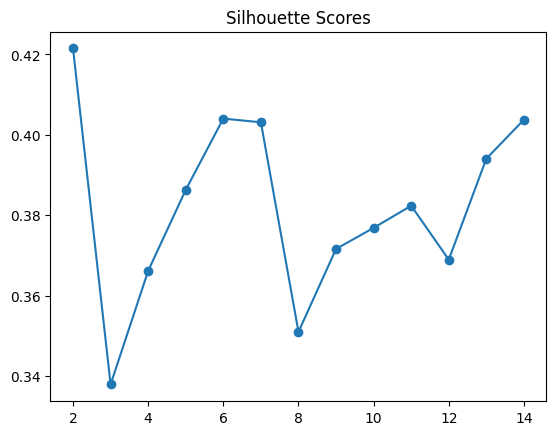

In [65]:
# Plot Silhouette Score
plt.plot(SH.keys(), SH.values(), marker='o', )
plt.title('Silhouette Scores')
plt.show()

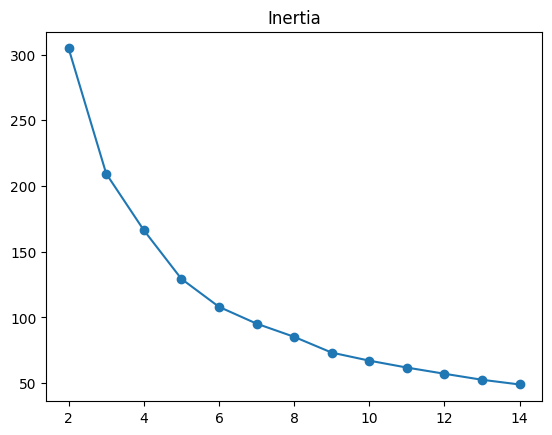

In [66]:
# Plot Inertia
plt.plot(IN.keys(), IN.values(), marker='o')
plt.title('Inertia')
plt.show()

We determine $k=6$ to be the optimal amount of clusters, as it maximizes silhouette score and gives us a low inertia variability (elbow method) at the same time.

In [67]:
# Initialize the KMeans clustering model with 6 clusters, a fixed random seed
inner_KMeans_clusterer = KMeans(6, random_state=42, n_init=100)

# Fit the model and predict cluster labels
labels = inner_KMeans_clusterer.fit_predict(inner.loc[:, ['newP', 'newW', 'newC']])

# Add the subclusterer labels to Cluster 0's DataFrame
inner.loc[:, 'InnerKMeansLabel'] = labels

# Create a 3D Scatter Plot to visualise the new clusters
px.scatter_3d(inner, x='Publications', y='wordcount', z='coursecount', color='InnerKMeansLabel') 

C:\Users\joana\AppData\Local\Temp\ipykernel_30788\3228754982.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Let us now perform the analysis of the clusters.

---

**General Overview**

---

We can see that the cluster sizes are still as not balanced, although the situation is not as extremely imbalanced as before. This suggests that there's a "principal" part of the main teachers body, being cluster 3.

Moreover, we can see that there are still parse clusters, with *Cluster 5* having only 7 elements.

In [68]:
display(inner[['Name', 'InnerKMeansLabel']].groupby('InnerKMeansLabel').count().style.bar())

,Name
InnerKMeansLabel,
0,30
1,28
2,27
3,88
4,26
5,7


---

**Subclusters 0, 1, 3**: Lecturers with different backgrounds.

---

Subclusters 0, 1, 3 form the majority of the subclusters.

These subclusters are dominated by adjunct lecturers, who primarily focus on teaching, as they have low - if none - amount of publications. These individuals are often tasked with few and specific courses or assignments and generally lack a central focus on academic research. The composition highlights the importance of their contribution to curriculum diversity and practical teaching expertise.

In [69]:
subclusters_0 = inner[inner['InnerKMeansLabel'].isin([0,1,3])]
display(subclusters_0[['Name', 'Title']].groupby('Title').count().style.bar())
display(subclusters_0.describe().loc[['mean', 'std', 'min', 'max']].iloc[:, :3])

,Name
Title,
Adjunct Lecturer,101
Invited Assistant Professor,5
Invited Associate Professor,4
Invited Full Professor,2
Invited Teaching Assistant,9
Professor of the Practice,24
Research Assistant,1


,Publications,wordcount,coursecount
mean,0.226027,109.335616,1.479452
std,0.994957,87.766404,0.716497
min,0.000000,4.000000,1.000000
max,9.000000,535.000000,4.000000


We can observe that these three clusters differ from each other only in terms of word count. This tells us that these types of lecturers could have had different types of backgrounds; some of them could be coming from a long professional career having a higher wordcount (subcluster 0), others can be just recently-graduated people having started their teaching career (subcluster 1). However, an intermediate situation seems to be the most common (subcluster 3).

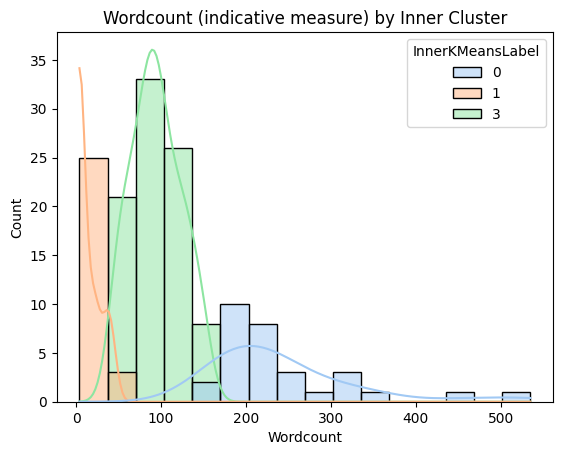

In [70]:
ax = sns.histplot(data=subclusters_0[['wordcount', 'InnerKMeansLabel']], x='wordcount', hue='InnerKMeansLabel', kde=True, palette=sns.color_palette('pastel')[0:3])
ax.set_xlabel('Wordcount')
ax.set_title('Wordcount (indicative measure) by Inner Cluster')
plt.show()


---

**Subcluster 4**: Senior Expertise with Teaching Orientation

---

As we can see, this subcluster contains teachers with a moderate coursecount, but with a low amount of publications (0-9) anyways.

We can see that this subcluster mainly features invited professors, professors of the practice and invited teaching assistants, blending senior academic expertise with teaching-focused roles; basically, we are talking about teachers who are mainly oriented towards teaching subjects.


In [71]:
subcluster_1 = inner[inner['InnerKMeansLabel'] == 4]
display(subcluster_1[['Name', 'Title']].groupby('Title').count().style.bar())
display(subcluster_1.describe().loc[['mean', 'std', 'min', 'max']].iloc[:, :3])


,Name
Title,
Adjunct Lecturer,5
Invited Assistant Professor,8
Invited Teaching Assistant,7
Professor of the Practice,5
Research Assistant,1


,Publications,wordcount,coursecount
mean,2.730769,107.769231,5.653846
std,2.850371,63.644832,1.354764
min,0.000000,4.000000,4.000000
max,9.000000,264.000000,9.000000


---

**Subcluster 2**: Research Ecosystem Contributors

---

This subcluster contains teachers with a low-moderate amount of publications (2-26).

We can infer that subcluster 2 represents a blend of full professors, research assistants, and adjunct lecturers, emphasizing a strong focus on high-quality research. Their roles contribute significantly to the institution’s academic reputation by fostering innovation and maintaining a robust research ecosystem, while doubling as lecturers. 



In [72]:
subcluster_2 = inner[inner['InnerKMeansLabel'] == 2]
display(subcluster_2[['Name', 'Title']].groupby('Title').count().style.bar())
display(subcluster_2.describe().loc[['mean', 'std', 'min', 'max']].iloc[:, :3])


,Name
Title,
Adjunct Lecturer,9
Full Professor,1
Invited Assistant Professor,4
Invited Associate Professor,1
Invited Full Professor,1
Invited Teaching Assistant,2
Professor of the Practice,7
Research Assistant,2


,Publications,wordcount,coursecount
mean,8.592593,137.777778,1.555556
std,5.917765,52.851267,0.800641
min,2.000000,63.000000,1.000000
max,26.000000,280.000000,4.000000


---

**Subcluster 5**: Research Ecosystem Contributors

---
This is the most sparse subcluster of every subcluster, making it quite peculiar.

We can see that this subcluster includes full professors, associate professors, and invited full professors, highlighting seniority and strong academic contributions. In fact, they seem to have a moderate amount of publications (25-76) and courses (2-6). The group is characterized by a focus on research excellence and advancing institutional goals.


In [73]:
subcluster_3 = inner[inner['InnerKMeansLabel'] == 5]
display(subcluster_3[['Name', 'Title']].groupby('Title').count().style.bar())
display(subcluster_3.describe().loc[['mean', 'std', 'min', 'max']].iloc[:, :3])


,Name
Title,
Associate Professor,1
Invited Assistant Professor,2
Invited Full Professor,3
Professor of the Practice,1


,Publications,wordcount,coursecount
mean,46.285714,154.428571,3.714286
std,15.829448,68.731015,1.253566
min,25.000000,84.000000,2.000000
max,76.000000,256.000000,6.000000


##### **3.7. - Extra: Word Cloud Cluster**
As an extra, we thought that it would have been interesting to make word clouds for each generated sub clusters, to see if there are recurrent topics or themes between the teachers.

In [74]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
def gen_wordcloud(df, n, verbose=False):
    """
    Given a DataFrame with 'InnerKMeansLabel' and the cluster label, this function 
    generates a wordcloud of the teacher's biographies belonging to cluster n.
    """
    print(f'Handling cluster {n}\n'*verbose, end='')

    # Try to filter the dataframe for the teachers belonging to cluster n
    try:
        df_target = df[df['InnerKMeansLabel'] == n].copy()
    except Exception as e: 
        raise Exception('Wrong dataframe')  # Raise an error if the filtering fails
    
    dictionary = []

    # Append all the biographies of cluster n to a list
    for bio in df_target['Biography']:
        dictionary.append(bio)

    # Join all biographies into a single string
    bigS = " ".join(dictionary)

    # Set of common words to exclude from the wordcloud
    stops = set(stopwords.words('english'))
    # Add additional stopwords specific to this dataset
    stops.add('NOVA')
    stops.add('IMS')
    stops.add('since')

    # Create the wordcloud
    wc = WordCloud(width = 3000, height = 1500, stopwords=stops).generate_from_text(bigS)
    # Add title
    plt.title(f'Cluster {n}')
    
    plt.imshow(wc)

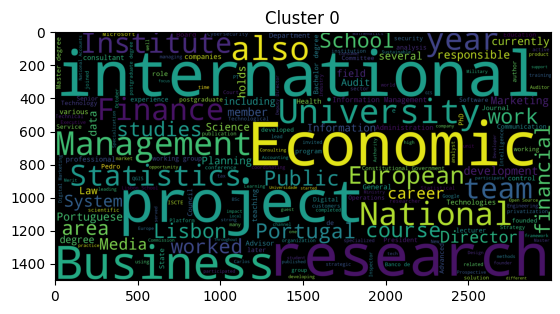

In [76]:
gen_wordcloud(inner, 0)

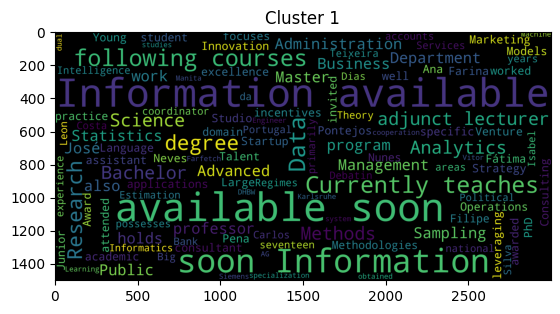

In [77]:
gen_wordcloud(inner, 1)

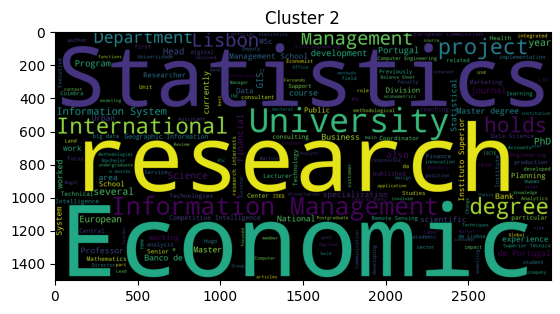

In [78]:
gen_wordcloud(inner, 2)

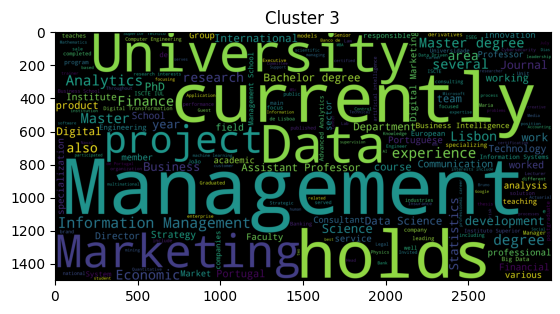

In [79]:
gen_wordcloud(inner, 3)

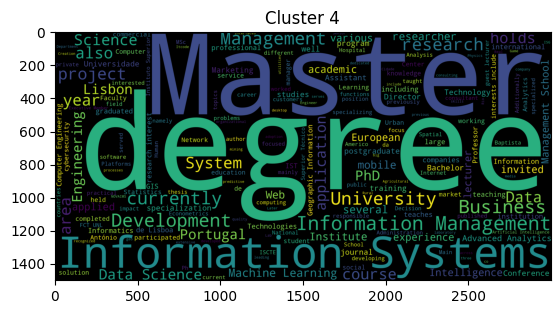

In [80]:
gen_wordcloud(inner, 4)

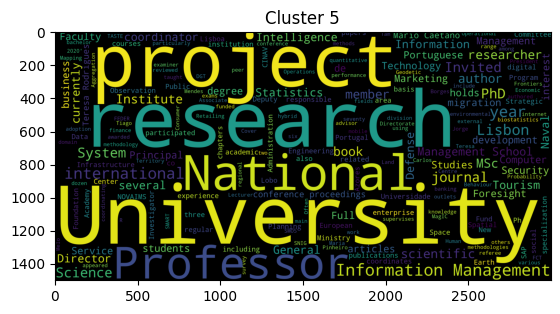

In [81]:
gen_wordcloud(inner, 5)

The analysis of these wordclouds are actually quite interesting and are according to our cluster analysis:
- **WordCloud 0:** According to our cluster analysis, cluster 0 would be the professors with a long lasting professional carrer. The biggest word of the wordcloud is "international", which is interesting because it might indicate that these professor's carreer is even international.
- **WordCloud 1:** It is interesting because we said that cluster 1 would involve people recently graduated and their wordcloud signals that they dont have biographies yet (words: available, soon), and also suggest they are young (words like bachelor, young).
- **WordCloud 2:** We said this cluster would mainly be researchers and the main word is "research".
- **WordCloud 4:** We said this cluster would be teachers mainly oriented to teach practical subjects and with high academic expertise, which is alluded to by words like "master" and "degree".
- **WordCloud 5:** According to the cluster analysis, cluster 5 would have teachers focused on research and with a high amount of publications, which shows in the worcloud with words like "journal", "articles", "project".